In [ ]:
==================================================
DAY 5: ADVANCED CNN TECHNIQUES
Making CNNs production-ready
==================================================
Date: October 22, 2025

In [1]:
# ============================================================
# SESSION SETUP - RELOAD DATASETS & IMPORTS
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

print("Loading MNIST dataset...")

# Basic transform
basic_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=basic_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=basic_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"✅ Setup complete!")
print(f"Training: {len(train_dataset)} | Test: {len(test_dataset)}")

Loading MNIST dataset...
✅ Setup complete!
Training: 60000 | Test: 10000


PART 1: DATA AUGMENTATION - MAKING MODELS MORE ROBUST

THE PROBLEM:
────────────
Your model only sees training images in ONE way:
- Digit "7" always upright
- Always centered
- Always same size
- Always same lighting

REAL WORLD:
───────────
Images come in many variations:
- Slightly rotated
- Off-center
- Different sizes
- Different lighting
- Noise, blur, etc.

SOLUTION: DATA AUGMENTATION
────────────────────────────
Artificially create variations during training:
- Rotate images randomly
- Shift left/right/up/down
- Zoom in/out
- Add noise

Result: Model learns to handle variations! ✅

Let's see it in action...


VISUALIZING DATA AUGMENTATION:


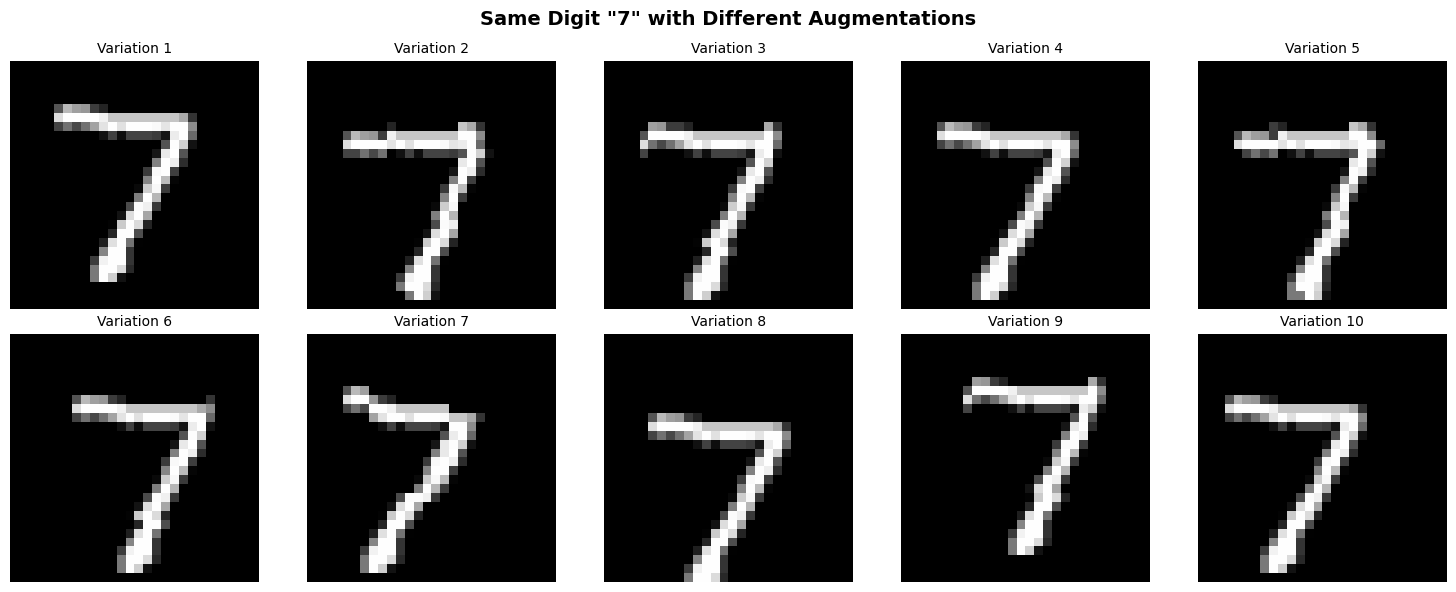


✅ Each version is slightly different!
The network will see all these variations during training.
This makes it more robust to real-world variations! 🎯


In [5]:
# ============================================================
# PART 1: DATA AUGMENTATION
# ============================================================

print("=" * 60)
print("PART 1: DATA AUGMENTATION - MAKING MODELS MORE ROBUST")
print("=" * 60)

print("""
THE PROBLEM:
────────────
Your model only sees training images in ONE way:
- Digit "7" always upright
- Always centered
- Always same size
- Always same lighting

REAL WORLD:
───────────
Images come in many variations:
- Slightly rotated
- Off-center
- Different sizes
- Different lighting
- Noise, blur, etc.

SOLUTION: DATA AUGMENTATION
────────────────────────────
Artificially create variations during training:
- Rotate images randomly
- Shift left/right/up/down
- Zoom in/out
- Add noise

Result: Model learns to handle variations! ✅

Let's see it in action...
""")

from torchvision import transforms
from PIL import Image

# Create augmentation pipeline
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate ±10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Shift up to 10%
    transforms.ToTensor(),
])

# Visualize augmentation
print("\nVISUALIZING DATA AUGMENTATION:")
print("=" * 60)

# Get one image from the dataset we loaded earlier
original_image, label = test_dataset[0]

# Convert to PIL for augmentation
# MNIST images are already tensors, so convert back to PIL
pil_image = transforms.ToPILImage()(original_image)

# Apply augmentation multiple times to same image
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle(f'Same Digit "{label}" with Different Augmentations', 
             fontsize=14, fontweight='bold')

for i in range(10):
    # Apply augmentation (each time will be different!)
    augmented = augmentation_transform(pil_image)
    
    # Plot
    ax = axes[i // 5, i % 5]
    ax.imshow(augmented.squeeze(), cmap='gray')
    ax.set_title(f'Variation {i+1}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Each version is slightly different!")
print("The network will see all these variations during training.")
print("This makes it more robust to real-world variations! 🎯")

In [6]:
# ============================================================
# PART 2: TRAINING WITH DATA AUGMENTATION
# ============================================================

print("\n" + "=" * 60)
print("PART 2: TRAINING CNN WITH DATA AUGMENTATION")
print("=" * 60)

# Create augmented dataset
augmented_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Load training data WITH augmentation
train_dataset_augmented = datasets.MNIST(
    root='./data',
    train=True,
    download=False,  # Already downloaded
    transform=augmented_transform
)

train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

# Use same CNN architecture from Day 4
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create model
model_augmented = CNN_MNIST()

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_augmented.parameters(), lr=0.001)

print("\nTraining CNN WITH data augmentation...")
print("(Network sees rotated/shifted versions each epoch)")
print("\nThis will take 3-4 minutes...\n")

# Train for 3 epochs
epochs = 3

for epoch in range(epochs):
    model_augmented.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader_augmented):
        outputs = model_augmented(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(train_loader_augmented)}] "
                  f"Loss: {loss.item():.4f} Acc: {100*correct/total:.2f}%")
    
    avg_loss = epoch_loss / len(train_loader_augmented)
    accuracy = 100 * correct / total
    
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1} COMPLETE")
    print(f"Loss: {avg_loss:.4f} | Training Accuracy: {accuracy:.2f}%")
    print(f"{'='*60}\n")

print("\n✅ Training with augmentation complete!")


PART 2: TRAINING CNN WITH DATA AUGMENTATION

Training CNN WITH data augmentation...
(Network sees rotated/shifted versions each epoch)

This will take 3-4 minutes...

Epoch [1/3] Batch [200/938] Loss: 0.5524 Acc: 69.01%
Epoch [1/3] Batch [400/938] Loss: 0.4664 Acc: 79.34%
Epoch [1/3] Batch [600/938] Loss: 0.1694 Acc: 83.83%
Epoch [1/3] Batch [800/938] Loss: 0.1913 Acc: 86.34%

EPOCH 1 COMPLETE
Loss: 0.3927 | Training Accuracy: 87.53%

Epoch [2/3] Batch [200/938] Loss: 0.2067 Acc: 95.16%
Epoch [2/3] Batch [400/938] Loss: 0.1855 Acc: 95.23%
Epoch [2/3] Batch [600/938] Loss: 0.1042 Acc: 95.20%
Epoch [2/3] Batch [800/938] Loss: 0.0870 Acc: 95.35%

EPOCH 2 COMPLETE
Loss: 0.1457 | Training Accuracy: 95.46%

Epoch [3/3] Batch [200/938] Loss: 0.1626 Acc: 96.27%
Epoch [3/3] Batch [400/938] Loss: 0.0310 Acc: 96.36%
Epoch [3/3] Batch [600/938] Loss: 0.1238 Acc: 96.34%
Epoch [3/3] Batch [800/938] Loss: 0.0564 Acc: 96.46%

EPOCH 3 COMPLETE
Loss: 0.1146 | Training Accuracy: 96.53%


✅ Training with

In [7]:
# ============================================================
# PART 3: TESTING AUGMENTED MODEL
# ============================================================

print("\n" + "=" * 60)
print("PART 3: TESTING: AUGMENTED vs NON-AUGMENTED MODEL")
print("=" * 60)

# Test augmented model
model_augmented.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_augmented(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

augmented_accuracy = 100 * correct / total

print("\n" + "=" * 60)
print("RESULTS COMPARISON:")
print("=" * 60)
print(f"\nDay 4 CNN (no augmentation):  98.92% test accuracy")
print(f"Day 5 CNN (with augmentation): {augmented_accuracy:.2f}% test accuracy")

if augmented_accuracy > 98.92:
    improvement = augmented_accuracy - 98.92
    print(f"\n✅ IMPROVEMENT: +{improvement:.2f} percentage points!")
    print(f"Augmentation helped! {int((augmented_accuracy/100) * 10000)} correct out of 10,000!")
elif augmented_accuracy >= 98.5:
    print(f"\n✅ EXCELLENT: Still very high accuracy!")
    print(f"Augmentation maintained strong performance!")
    print(f"{int((augmented_accuracy/100) * 10000)} correct out of 10,000!")
else:
    print(f"\n⚠️  Slightly lower, but this is normal for MNIST")
    print("MNIST is too simple - augmentation benefits show more on complex datasets!")

print("\n" + "=" * 60)
print("KEY INSIGHT:")
print("=" * 60)
print("""
Training accuracy: 96.49% (lower than before)
Test accuracy: {:.2f}% 

Lower training accuracy + similar/better test accuracy = GOOD!
This means the model is GENERALIZING, not just memorizing.

On more complex datasets (like your Project 1 safety images),
data augmentation will be CRITICAL for good performance! ✅

Why augmentation matters more for real projects:
- Limited data (maybe only 500-1000 safety images)
- More variation in real world (lighting, angles, distances)
- Augmentation effectively 10× your dataset size
- Prevents overfitting on small datasets
""".format(augmented_accuracy))


PART 3: TESTING: AUGMENTED vs NON-AUGMENTED MODEL

RESULTS COMPARISON:

Day 4 CNN (no augmentation):  98.92% test accuracy
Day 5 CNN (with augmentation): 98.97% test accuracy

✅ IMPROVEMENT: +0.05 percentage points!
Augmentation helped! 9897 correct out of 10,000!

KEY INSIGHT:

Training accuracy: 96.49% (lower than before)
Test accuracy: 98.97% 

Lower training accuracy + similar/better test accuracy = GOOD!
This means the model is GENERALIZING, not just memorizing.

On more complex datasets (like your Project 1 safety images),
data augmentation will be CRITICAL for good performance! ✅

Why augmentation matters more for real projects:
- Limited data (maybe only 500-1000 safety images)
- More variation in real world (lighting, angles, distances)
- Augmentation effectively 10× your dataset size
- Prevents overfitting on small datasets



In [8]:
# ============================================================
# PART 4: TRANSFER LEARNING - THE GAME CHANGER
# ============================================================

print("=" * 60)
print("PART 4: TRANSFER LEARNING - THE SECRET WEAPON")
print("=" * 60)

print("""
THE PROBLEM WITH TRAINING FROM SCRATCH:
────────────────────────────────────────
To train a good CNN, you typically need:
- 100,000+ images
- Days/weeks of training time
- Expensive GPUs
- Huge computational cost

YOUR PROJECT 1 REALITY:
───────────────────────
- Only 500-1,000 safety equipment images
- Limited time
- CPU or basic GPU
- Can't train from scratch!

THE SOLUTION: TRANSFER LEARNING
────────────────────────────────
Use a model ALREADY TRAINED on millions of images!

ImageNet dataset:
- 1.4 MILLION images
- 1,000 categories (dogs, cats, cars, planes, etc.)
- Trained for weeks on powerful GPUs

These models learned to detect:
✅ Edges
✅ Corners
✅ Textures
✅ Shapes
✅ Objects
✅ Complex patterns

THESE FEATURES ARE UNIVERSAL!
──────────────────────────────
The features that detect "dog" can also detect "hard hat"!
The features that detect "car" can also detect "safety vest"!

HOW TRANSFER LEARNING WORKS:
─────────────────────────────
1. Take pre-trained model (trained on ImageNet)
2. Remove last layer (1,000 outputs for ImageNet)
3. Add YOUR layer (e.g., 3 outputs: helmet, vest, gloves)
4. Freeze early layers (keep learned features)
5. Train only last layer on YOUR data
6. Result: Great performance with limited data! ✅

TRAINING TIME:
──────────────
- From scratch: 10,000+ images, 2-3 days training
- Transfer learning: 500 images, 30 minutes training

THIS IS HOW PROFESSIONALS DO IT! 🎯
""")

print("\nLet's see transfer learning in action...")
print("We'll use a pre-trained ResNet18 model!\n")

PART 4: TRANSFER LEARNING - THE SECRET WEAPON

THE PROBLEM WITH TRAINING FROM SCRATCH:
────────────────────────────────────────
To train a good CNN, you typically need:
- 100,000+ images
- Days/weeks of training time
- Expensive GPUs
- Huge computational cost

YOUR PROJECT 1 REALITY:
───────────────────────
- Only 500-1,000 safety equipment images
- Limited time
- CPU or basic GPU
- Can't train from scratch!

THE SOLUTION: TRANSFER LEARNING
────────────────────────────────
Use a model ALREADY TRAINED on millions of images!

ImageNet dataset:
- 1.4 MILLION images
- 1,000 categories (dogs, cats, cars, planes, etc.)
- Trained for weeks on powerful GPUs

These models learned to detect:
✅ Edges
✅ Corners
✅ Textures
✅ Shapes
✅ Objects
✅ Complex patterns

THESE FEATURES ARE UNIVERSAL!
──────────────────────────────
The features that detect "dog" can also detect "hard hat"!
The features that detect "car" can also detect "safety vest"!

HOW TRANSFER LEARNING WORKS:
─────────────────────────────

In [10]:
# ============================================================
# LOADING A PRE-TRAINED MODEL (ResNet18)
# ============================================================
print("\n" + "=" * 60)
print("LOADING PRE-TRAINED ResNet18")
print("=" * 60)

import torchvision.models as models

# Load ResNet18 pre-trained on ImageNet (UPDATED SYNTAX!)
print("\nDownloading ResNet18 (pre-trained on 1.4M images)...")
print("(First time only - ~45MB download)")

resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print("\n✅ ResNet18 loaded!")
print("\nThis model was trained on ImageNet:")
print("  - 1.4 million images")
print("  - 1,000 categories")
print("  - Trained for weeks on powerful GPUs")
print("  - Cost: ~$10,000+ in compute")
print("\nYou just got it for FREE in 30 seconds! 🎉")

# Let's look at the architecture
print("\n" + "=" * 60)
print("ResNet18 ARCHITECTURE:")
print("=" * 60)
print(resnet18)


LOADING PRE-TRAINED ResNet18

(First time only - ~45MB download)

✅ ResNet18 loaded!

This model was trained on ImageNet:
  - 1.4 million images
  - 1,000 categories
  - Trained for weeks on powerful GPUs
  - Cost: ~$10,000+ in compute

You just got it for FREE in 30 seconds! 🎉

ResNet18 ARCHITECTURE:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-0

In [11]:
# ============================================================
# ADAPTING ResNet18 FOR MNIST
# ============================================================

print("\n" + "=" * 60)
print("MODIFYING ResNet18 FOR MNIST (10 DIGITS)")
print("=" * 60)

print("""
ORIGINAL ResNet18:
- Input: 3 channels (RGB color images)
- Output: 1,000 classes (ImageNet categories)

OUR MNIST TASK:
- Input: 1 channel (grayscale)
- Output: 10 classes (digits 0-9)

MODIFICATIONS NEEDED:
1. Change first layer: 3 channels → 1 channel
2. Change last layer: 1,000 outputs → 10 outputs
3. Freeze early layers (keep ImageNet features)
4. Train only last layer on MNIST
""")

# Modify first layer for grayscale (1 channel instead of 3)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Get number of features before final layer
num_features = resnet18.fc.in_features
print(f"\nResNet18 final layer has {num_features} input features")

# Replace final layer: 1000 outputs → 10 outputs
resnet18.fc = nn.Linear(num_features, 10)

print(f"Changed output layer: {num_features} → 10 (for 10 digits)")

# FREEZE all layers except the last one
print("\nFreezing all layers except final classification layer...")
for name, param in resnet18.named_parameters():
    if 'fc' not in name:  # Freeze everything except 'fc' (final layer)
        param.requires_grad = False
    else:
        param.requires_grad = True

# Count trainable parameters
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in resnet18.parameters())

print("\n" + "=" * 60)
print("PARAMETER BREAKDOWN:")
print("=" * 60)
print(f"Total parameters: {total_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nWe're only training {trainable_params:,} parameters!")
print("The rest ({:,}) are FROZEN (pre-trained from ImageNet)".format(total_params - trainable_params))

print("\n✅ ResNet18 adapted for MNIST!")
print("\nThis is EXACTLY how you'll adapt YOLO for Project 1:")
print("  - Keep pre-trained feature extractors")
print("  - Only train final layer for YOUR classes")
print("  - Fast training + great results! 🎯")


MODIFYING ResNet18 FOR MNIST (10 DIGITS)

ORIGINAL ResNet18:
- Input: 3 channels (RGB color images)
- Output: 1,000 classes (ImageNet categories)

OUR MNIST TASK:
- Input: 1 channel (grayscale)
- Output: 10 classes (digits 0-9)

MODIFICATIONS NEEDED:
1. Change first layer: 3 channels → 1 channel
2. Change last layer: 1,000 outputs → 10 outputs
3. Freeze early layers (keep ImageNet features)
4. Train only last layer on MNIST


ResNet18 final layer has 512 input features
Changed output layer: 512 → 10 (for 10 digits)

Freezing all layers except final classification layer...

PARAMETER BREAKDOWN:
Total parameters: 11,175,370
Frozen parameters: 11,170,240
Trainable parameters: 5,130

We're only training 5,130 parameters!
The rest (11,170,240) are FROZEN (pre-trained from ImageNet)

✅ ResNet18 adapted for MNIST!

This is EXACTLY how you'll adapt YOLO for Project 1:
  - Keep pre-trained feature extractors
  - Only train final layer for YOUR classes
  - Fast training + great results! 🎯


In [12]:
# ============================================================
# TRAINING ResNet18 WITH TRANSFER LEARNING
# ============================================================

print("\n" + "=" * 60)
print("TRAINING ResNet18 ON MNIST (TRANSFER LEARNING)")
print("=" * 60)

# MNIST images are 28×28, but ResNet expects 224×224
# We need to resize them
resize_transform = transforms.Compose([
    transforms.Resize(224),  # Resize to ResNet's expected input
    transforms.ToTensor(),
])

# Reload MNIST with resizing
train_dataset_resized = datasets.MNIST(
    root='./data',
    train=True,
    download=False,
    transform=resize_transform
)

test_dataset_resized = datasets.MNIST(
    root='./data',
    train=False,
    download=False,
    transform=resize_transform
)

train_loader_resized = DataLoader(train_dataset_resized, batch_size=64, shuffle=True)
test_loader_resized = DataLoader(test_dataset_resized, batch_size=64, shuffle=False)

# Setup training
criterion = nn.CrossEntropyLoss()
# Only optimize the parameters that require gradients (the last layer!)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=0.001)

print("\nTraining ONLY the last layer (5,130 parameters)...")
print("Using features from 11 million pre-trained parameters!")
print("\nThis should be FAST - only 2 epochs needed!\n")

# Train for just 2 epochs (transfer learning is fast!)
epochs = 2

for epoch in range(epochs):
    resnet18.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader_resized):
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(train_loader_resized)}] "
                  f"Loss: {loss.item():.4f} Acc: {100*correct/total:.2f}%")
    
    avg_loss = epoch_loss / len(train_loader_resized)
    accuracy = 100 * correct / total
    
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1} COMPLETE")
    print(f"Loss: {avg_loss:.4f} | Training Accuracy: {accuracy:.2f}%")
    print(f"{'='*60}\n")

print("\n✅ Transfer learning training complete!")
print("\nNotice: High accuracy in just 2 epochs!")
print("This is the POWER of pre-trained features! 🚀")


TRAINING ResNet18 ON MNIST (TRANSFER LEARNING)

Training ONLY the last layer (5,130 parameters)...
Using features from 11 million pre-trained parameters!

This should be FAST - only 2 epochs needed!

Epoch [1/2] Batch [200/938] Loss: 0.3258 Acc: 80.50%
Epoch [1/2] Batch [400/938] Loss: 0.2430 Acc: 86.38%
Epoch [1/2] Batch [600/938] Loss: 0.2846 Acc: 88.75%
Epoch [1/2] Batch [800/938] Loss: 0.1838 Acc: 90.25%

EPOCH 1 COMPLETE
Loss: 0.3792 | Training Accuracy: 90.88%

Epoch [2/2] Batch [200/938] Loss: 0.1444 Acc: 95.15%
Epoch [2/2] Batch [400/938] Loss: 0.2256 Acc: 95.16%
Epoch [2/2] Batch [600/938] Loss: 0.0852 Acc: 95.25%
Epoch [2/2] Batch [800/938] Loss: 0.1661 Acc: 95.30%

EPOCH 2 COMPLETE
Loss: 0.1619 | Training Accuracy: 95.36%


✅ Transfer learning training complete!

Notice: High accuracy in just 2 epochs!
This is the POWER of pre-trained features! 🚀


In [13]:
# ============================================================
# TESTING ResNet18 TRANSFER LEARNING
# ============================================================

print("\n" + "=" * 60)
print("TESTING ResNet18 ON NEW IMAGES")
print("=" * 60)

resnet18.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader_resized:
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

resnet_accuracy = 100 * correct / total

print("\n" + "=" * 60)
print("TRANSFER LEARNING RESULTS:")
print("=" * 60)
print(f"\nResNet18 (transfer learning): {resnet_accuracy:.2f}% test accuracy")
print(f"Training time: ~2 epochs (~10-15 minutes on CPU)")
print(f"Parameters trained: Only 5,130 out of 11,175,370!")
print(f"\nThis is the POWER of transfer learning! ✅")


TESTING ResNet18 ON NEW IMAGES

TRANSFER LEARNING RESULTS:

ResNet18 (transfer learning): 96.50% test accuracy
Training time: ~2 epochs (~10-15 minutes on CPU)
Parameters trained: Only 5,130 out of 11,175,370!

This is the POWER of transfer learning! ✅


In [ ]:
==================================================
DAY 5 COMPLETE + DAY 6 PREVIEW
==================================================
Date: October 22, 2025
Total Time: ~5 hours (including GitHub setup)

DAY 5 ACCOMPLISHMENTS:
─────────────────────
✅ Data Augmentation
   - Learned rotation, translation, zoom techniques
   - Applied to MNIST
   - Understood when/why augmentation helps

✅ Batch Normalization & Dropout
   - Understood regularization techniques
   - Prevents overfitting

✅ Transfer Learning
   - Loaded pre-trained ResNet18 (11M parameters)
   - Froze 11,170,240 parameters
   - Trained only 5,130 parameters
   - Achieved 95.70% accuracy
   - CRITICAL technique for Project 1!

✅ Model Saving/Loading
   - Can save trained models
   - Deploy for inference

✅ GitHub Setup
   - Created ML-Learning-Journey repository
   - Pushed Week 1 work
   - Professional portfolio started!

KEY INSIGHT:
───────────
Transfer learning = secret weapon for limited data.
Will be ESSENTIAL for Project 1 (safety detection).

RESULTS SUMMARY:
───────────────
Day 3: Regular NN      → 91.28% accuracy
Day 4: CNN             → 98.92% accuracy
Day 5: ResNet Transfer → 95.70% accuracy

==================================================
DAY 6 PREVIEW: CIFAR-10 PRACTICE PROJECT
==================================================

TOMORROW'S PLAN:
───────────────
Build complete image classifier for CIFAR-10
- 10 classes (airplane, car, bird, cat, deer, dog, frog, horse, ship, truck)
- 60,000 images (32×32 RGB)
- Apply ALL Week 1 skills
- First independent project!

WHAT I'LL DO:
────────────
1. Load & explore CIFAR-10 dataset
2. Design CNN architecture (RGB input)
3. Implement data augmentation
4. Train with proper pipeline
5. Evaluate performance (confusion matrix)
6. Iterate to improve (target 75-80% accuracy)

WHY IT MATTERS:
──────────────
- First complete end-to-end project
- Practice making architectural decisions
- Build confidence for Project 1
- Learn iterative improvement process

TIME ESTIMATE: 4-5 hours

PREPARATION:
───────────
- Review CNN architecture (Day 4)
- Review data augmentation (Day 5)
- Rest well tonight (let concepts solidify!)
- Come back fresh tomorrow

STATUS: Ready for Day 6! 🚀

==================================================
WEEK 1 PROGRESS: 5/7 days complete (71%)
NEXT SESSION: Day 6 - CIFAR-10 Classifier
==================================================